# Reconstructing 3D buildings from Aerial LiDAR with Deep Learning
> * 🔬 Data Science
* 🥠 Deep Learning and Instance Segmentation

# Introduction

The workflow traditionally used to reconstruct 3D building models from aerial LiDAR is relatively straight-forward: the LiDAR point-cloud is transformed into a Digital Surface Model (DSM) raster, then inspected by human editors for buildings present. If a building is found, one or more polygon describing the roof form of the building is manually digitized, e.g. if it is a large hip roof with two gable outlets, there will be three polygons (one hip and two gables on top) drawn by the editor. Once all the roofs are described that way, a set of ArcGIS Procedural rules is applied to extrude the building models using the manually digitized roof segments, with heights and ridge directions computed from the DSM.

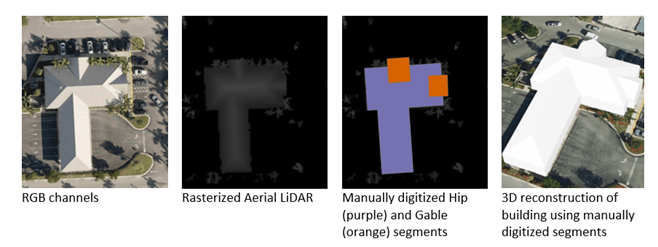

<center>Figure 1. 3D building reconstruction from Lidar example: a building with complex roof shape and its representation in visible spectrum (RGB), Aerial LiDAR, and corresponding roof segments digitized by a human editor. The last one is a 3D reconstruction of the same building using manually digitized masks and ArcGIS Procedural rules. </center>

The most time-consuming and expensive step in the above workflow is the manual search and digitization of the roof segment polygons from a DSM raster. In this notebook, we are going to focus on this challenging step and demonstrate how to detect instances of roof segments of various types using instance segmentation to make the process more efficient. The workflow consists of two major steps: (1) extract training data, (2) train a deep learning __instance segmentation__ model.

## Part 1 - Data Preparation

We started with two input data:
- A single-band raster layer with 2.25 square feet per pixel resolution converted from LiDAR point cloud (using the “[LAS Dataset to Raster](https://pro.arcgis.com/en/pro-app/tool-reference/conversion/las-dataset-to-raster.htm)” geoprocessing tool)
- A feature class that defines the location and label (i.e. flat, gable, hip, shed, mansard, vault, dome) of each roof segment.

The first challenge we ran into is that most pretrained deep learning models are based on 3 bands. In order to take advantage of these pretrained models, we need to add 2 additional bands. Since Lidar data is essentially elevantion, we decided to create two extra bands - slope and aspect, and stack them with the original Lidar elevantion band to compose a _3-band image_. This step can be done in ArcGIS Pro or ArcGIS Python API.

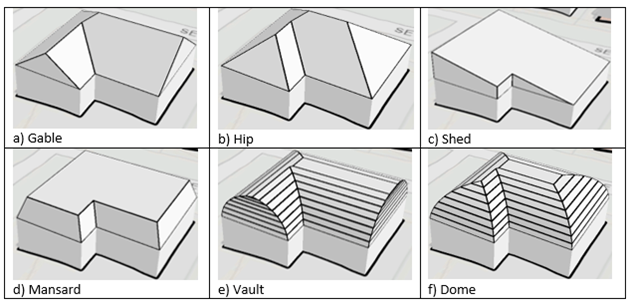

<center>Figure 2. Example of different roof types (flat not shown). </center>

### Connected to your GIS 

In [22]:
from arcgis import GIS

In [64]:
gis = GIS("home")

### Import input data

First, let's get the feature class that defines the location and label of each building.

<Item title:"buildings_subset" type:Feature Layer Collection owner:portaladmin>
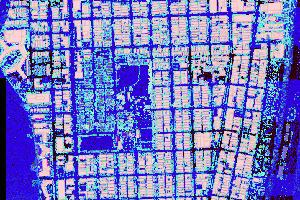

In [65]:
label_layer = gis.content.search("buildings_subset", item_type='Feature Layer Collection')[0]
label_layer

Now let's get 3-band input raster.

In [66]:
raster_layer = gis.content.search("Stretch_Composite Bands.tif", item_type="Imagery Layer")[0]
raster_layer

<Item title:"Stretch_Composite_Bands_tif" type:Imagery Layer owner:portaladmin>


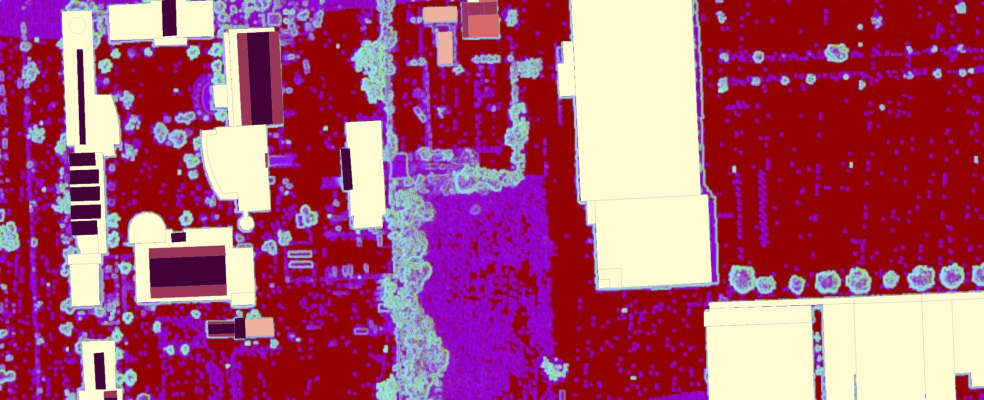

In [37]:
map1 = gis.map('Florida, USA')
map1

In [36]:
map1.add_layer(raster_layer)
map1.add_layer(label_layer, {"renderer":"ClassedColorRenderer", "field_name": "ClassValue"})

As you can see, different colors represents different kinds of roof segements.

### Export training data using `arcgis.learn`

Now we are ready to export training data. Note that unlike image segmentation and object detection, the metadata format is set to be `RCNN_Masks`. In this case, both the training chips and labeled images (also called _masks_ ) are raster images with spatial information. More detail can be found [here](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm). 

In [1]:
import arcgis
from arcgis import learn
arcgis.env.verbose = True

In [ ]:
export = learn.export_training_data(input_raster=input_raster_layer,
                                    output_location=samplefolder,
                                    input_class_data=building_label, 
                                    classvalue_field = "classValue",
                                    chip_format="TIFF", 
                                    tile_size={"x":512,"y":512}, 
                                    stride_size={"x":0,"y":0}, 
                                    metadata_format="RCNN_Masks",                                        
                                    context={"startIndex": 0, "exportAllTiles": False},
                                    gis = gis)

## Part 2 - model training

If you've already done part 1, you should already have the training chips. Please change the path to your own export training data folder that contains "images" and "labels" folder. Note that we set a relatively small `batch_size` here on purpose as instance segmentation is a more computationally intensive task compared with object detection and pixel-based classification. If you run into "insufficient memory" issue during training, you can come back to adjust it to meet your own needs. 

In [3]:
from arcgis.learn import prepare_data, MaskRCNN

In [6]:
data_path = r'to_your_data_folder'
data = prepare_data(data_path, batch_size=4)

### Visualize training data
To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them. Note that the masks representing difference roof segments are overlaid upon the original images with red and pink color.

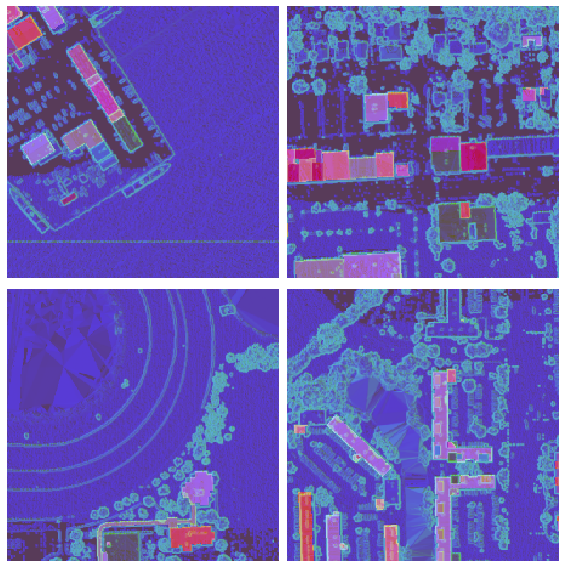

In [7]:
data.show_batch()

### Load model architecture

Here we use Mask R-CNN [1], a well recogonized instance algorithm, to detect roof segments (Figure 3). A Mask R-CNN model architecture and a pretrained model has already been predefined in `arcgis.learn`, so we can just define it with a single line. Please refer to the guide on our [developers' site](https://developers.arcgis.com/python/guide/geospatial-deep-learning/) for more information.

The idea of Mask R-CNN is is to detect objects in an image while simultaneously generating a high-quality segmentation mask for each instance. In other words, it is like a combination of Unet and SSD and does two jobs in one go. This is also why it is relatively computationally more intensive.

In [8]:
model = MaskRCNN(data)

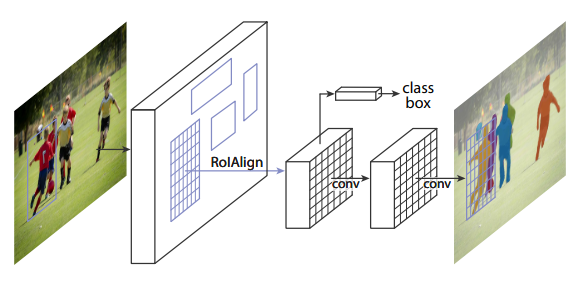
<center>Figure 3. Mask R-CNN framework for instance segmentation [1] </center>

### Train a model through learning rate tuning and transfer learning
[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. Python API provides a learning rate finder that automatically chooses the optimal learning rate fro you.

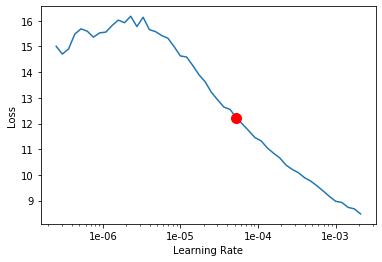

5.248074602497728e-05

In [9]:
# The users can visualize the learning rate of the model with comparative loss. 
model.lr_find()

Let's train it for a few epochs with the learning rate we have found. For the sake of time, we can start with 5 epochs.

In [10]:
model.fit(epochs=5, lr=5e-5)

epoch,train_loss,valid_loss,time
0,4.083294,4.054872,36:21
1,3.627678,3.758245,32:04
2,3.414474,3.597425,32:09
3,3.309737,3.525079,34:58
4,3.140495,3.484845,32:55


saving checkpoint.
Created model files at D:\mask_rcnn_export_3\models\checkpoint_2019-12-17_11-42-19
saving checkpoint.
Created model files at D:\mask_rcnn_export_3\models\checkpoint_2019-12-17_11-42-19
saving checkpoint.
Created model files at D:\mask_rcnn_export_3\models\checkpoint_2019-12-17_11-42-19
saving checkpoint.
Created model files at D:\mask_rcnn_export_3\models\checkpoint_2019-12-17_11-42-19
saving checkpoint.
Created model files at D:\mask_rcnn_export_3\models\checkpoint_2019-12-17_11-42-19
Created model files at D:\mask_rcnn_export_3\models\checkpoint_2019-12-17_11-42-19


### Visualize results in validation set
Now we have the model, let's look at how the model performs. There are 3 modes when visualizing the results.

- `bbox` - For visualizing only boundig boxes.
- `mask` - For visualizing only mask
- `bbox_mask` - For visualizing both mask and bounding boxes.

In the results below, building are represented with red, pink, and green color.

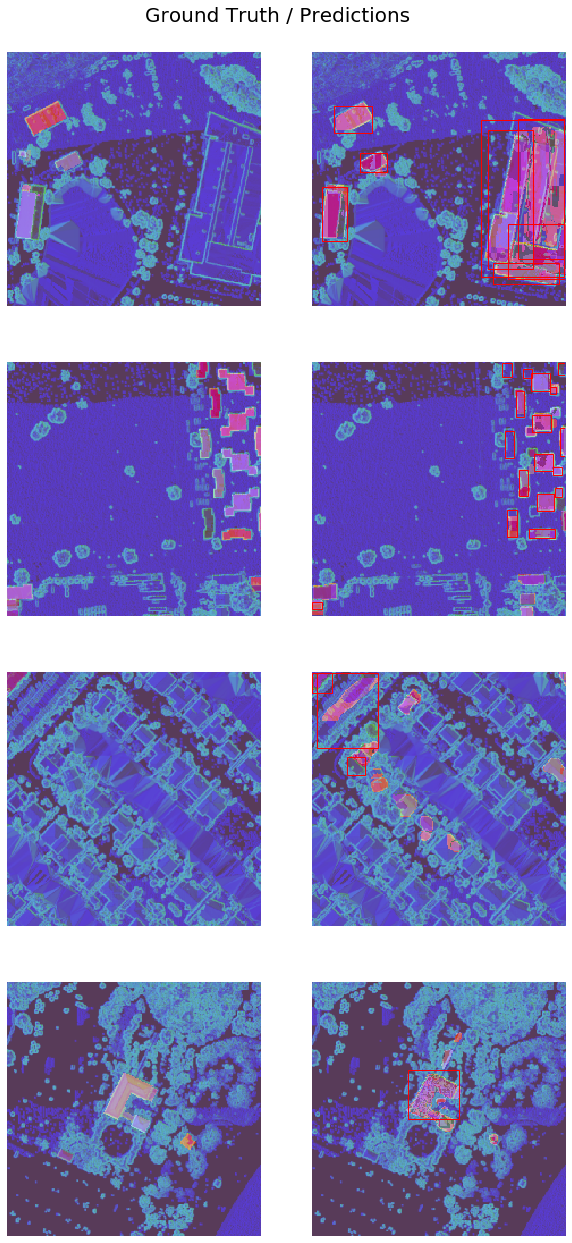

In [11]:
model.show_results(mode='bbox_mask')

As we can see, with only 5 epochs, we are already seeing promising results. Now let's train it for more epochs while unfreezing the model so we can train the backbone as well.

In [51]:
model.unfreeze()

In [52]:
model.fit(epochs=10, lr=slice(5e-7, 5e-5))

epoch,train_loss,valid_loss,time
0,3.024265,3.501689,38:10
1,3.035578,3.673829,34:18
2,3.520186,3.618556,34:18
3,3.077488,3.580595,34:17
4,2.889001,3.560575,34:20
5,2.709190,3.714221,34:19
6,2.484194,3.773277,34:21
7,2.243601,3.792150,34:12
8,2.108601,4.064532,33:53
9,2.050896,4.094315,34:09


saving checkpoint.
Created model files at D:\mask_rcnn_export_3\models\checkpoint_2019-12-19_11-19-58
Created model files at D:\mask_rcnn_export_3\models\checkpoint_2019-12-19_11-19-58


Note that the validation loss actually goes higher, but this doesn't necessarily mean the result is getting bad. Because our training data is also missing many buildings, the loss sometimes tells the actual model performance, so let's look at the actual results instead.

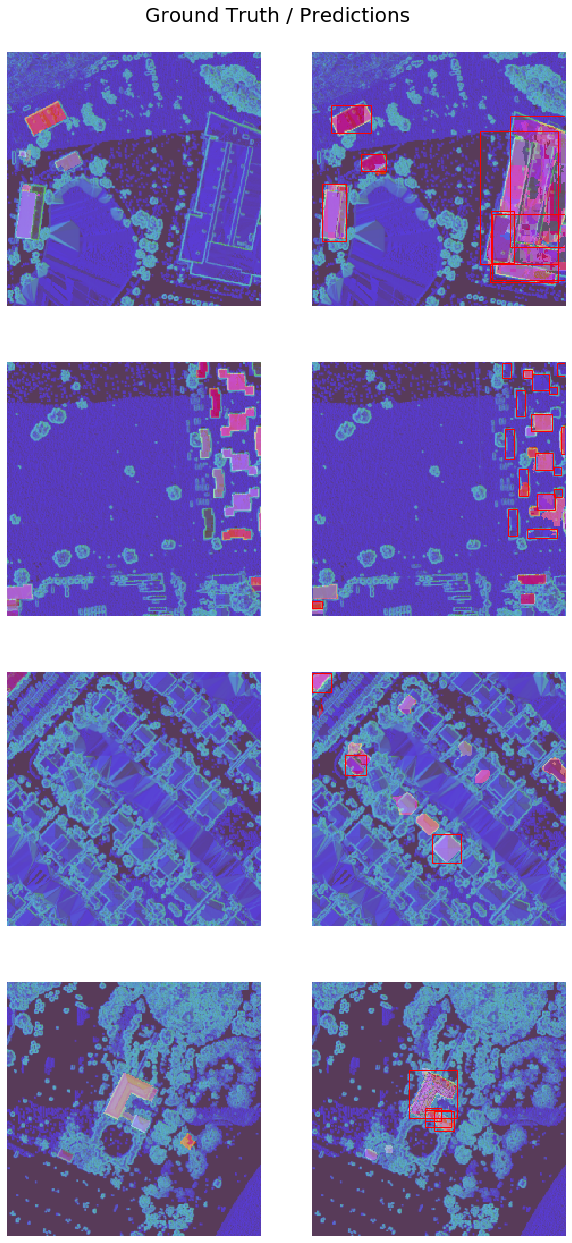

In [63]:
model.show_results(mode='bbox_mask')

Just by visually inspecting the prediction images, the results have been improved. Further improvment can be acheived through more sophisticated hyperparameter tuning. Let's save the model for further training or inference later. The model should be saved into a models folder in your folder. By default, it will be saved into your `data_path` that you specified in the very beginning of this notebook.

In [ ]:
model.save('model-final')

## Next steps

The next step is to extrude object detection results to 3D using traditional Geoprocessing tools and Procedural rules. First, we used the “[Regularize Building Footprint](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/regularize-building-footprint.htm)” tool from the 3D Analyst toolbox to regularize raw detections. Next, we used surface elevation and DSM rasters to acquire the base elevation for each building segment, and calculate the roof ridge direction. The final step was calling the “[Features from CityEngine Rules](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/features-from-cityengine-rules.htm)” GP tool which applied a procedural rule to these polygons to achieve a final reconstruction of the 3D buildings.

## Conclusion
In this notebook, we have covered a lot of ground. In part 1, we discussed how to prepare and export training data from aerial Lidar data. In part 2, we demonstrated how to prepare the input data, train a instance segmentation model, visualize the results, as well as apply the model to an unseen image using the deep learning module in ArcGIS API for Python. 

## References
[1] He, K., Gkioxari, G., Dollár, P. and Girshick, R., 2017. Mask r-cnn. In Proceedings of the IEEE international conference on computer vision (pp. 2961-2969).